0) 라이브러리 버전 확인하기
사용할 라이브러리 버전을 둘러봅시다.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


# 준비한 데이터
  + cats vs dogs 데이터셋

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteJWFDLD/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
ds_info.features["label"].num_classes

2

In [6]:
ds_info.features["label"].names

['cat', 'dog']

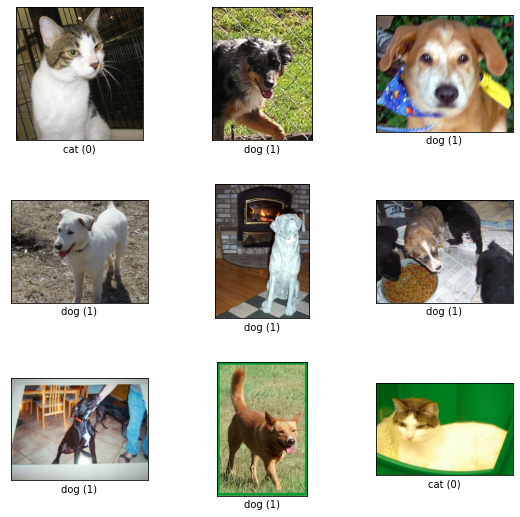

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

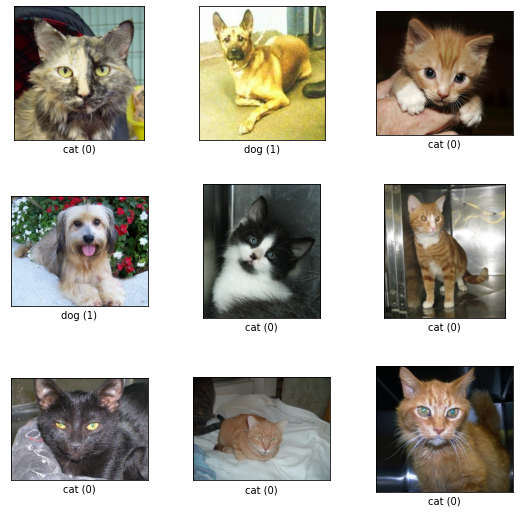

In [8]:
fig = tfds.show_examples(ds_test, ds_info)

## Input Normalization

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 1) ResNet 기본 블록 구성하기

이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.
<img src=https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png>

Q1. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.

A\
ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

## ) ResNet-34, ResNet-50 Complete Model

>ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

In [10]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [13]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [14]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

# 2. ResNet-34, ResNet-50 Complete Model
## ResNet-34

In [15]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_1[0

## ResNet-50

In [16]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_37 (BatchN  (None, 16, 16, 64)  256         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_37[

# 3. 일반 네트워크(plain network) 만들기

In [17]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [18]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## Plain-34

In [19]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_90 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_90 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_83 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_91 (Conv2D)          (None, 56, 56, 64)        369

## Plain-50

In [20]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_123 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_123 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_116 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_124 (Conv2D)         (None, 56, 56, 64)        416

In [21]:
del resnet_34
del resnet_50
del plain_34
del plain_50

# 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
## 모델별 학습

In [22]:
BATCH_SIZE = 16
EPOCH = 10

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- ResNet-34

In [23]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1163/1163 [==============================] - 110s 77ms/step - loss: 1.8777 - accuracy: 0.6011 - val_loss: 1.3010 - val_accuracy: 0.6136
Epoch 2/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.9867 - accuracy: 0.6845 - val_loss: 1.1125 - val_accuracy: 0.6210
Epoch 3/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.7161 - accuracy: 0.7391 - val_loss: 1.0695 - val_accuracy: 0.5300
Epoch 4/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6297 - accuracy: 0.7662 - val_loss: 0.8767 - val_accuracy: 0.6068
Epoch 5/10
1163/1163 [==============================] - 88s 75ms/step - loss: 0.5790 - accuracy: 0.7915 - val_loss: 0.7838 - val_accuracy: 0.6743
Epoch 6/10
1163/1163 [==============================] - 89s 76ms/step - loss: 0.5588 - accuracy: 0.8088 - val_loss: 0.6305 - val_accuracy: 0.7675
Epoch 7/10
1163/1163 [==============================] - 89s 76ms/step - loss: 0.5284 - accuracy: 0.8242 - val_loss: 0.5803 - val_accur

In [25]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_resnet_34.csv', index=False)

- ResNet-50

In [26]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1163/1163 [==============================] - 98s 73ms/step - loss: 4.5502 - accuracy: 0.6313 - val_loss: 3.1164 - val_accuracy: 0.6017
Epoch 2/10
1163/1163 [==============================] - 86s 74ms/step - loss: 2.1903 - accuracy: 0.7199 - val_loss: 1.8818 - val_accuracy: 0.6329
Epoch 3/10
1163/1163 [==============================] - 83s 72ms/step - loss: 1.3663 - accuracy: 0.7560 - val_loss: 3.0856 - val_accuracy: 0.5125
Epoch 4/10
1163/1163 [==============================] - 83s 72ms/step - loss: 0.9813 - accuracy: 0.7971 - val_loss: 1.7409 - val_accuracy: 0.5754
Epoch 5/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.8323 - accuracy: 0.8200 - val_loss: 0.8870 - val_accuracy: 0.7534
Epoch 6/10
1163/1163 [==============================] - 84s 73ms/step - loss: 0.7082 - accuracy: 0.8412 - val_loss: 1.1462 - val_accuracy: 0.5751
Epoch 7/10
1163/1163 [==============================] - 84s 73ms/step - loss: 0.6454 - accuracy: 0.8582 - val_loss: 1.0439 - val_accura

In [27]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_resnet_50.csv', index=False)

- Plain-34

In [28]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1163/1163 [==============================] - 93s 73ms/step - loss: 1.4124 - accuracy: 0.5077 - val_loss: 0.9986 - val_accuracy: 0.4909
Epoch 2/10
1163/1163 [==============================] - 83s 72ms/step - loss: 0.9089 - accuracy: 0.5173 - val_loss: 0.8325 - val_accuracy: 0.5155
Epoch 3/10
1163/1163 [==============================] - 84s 72ms/step - loss: 0.8480 - accuracy: 0.5142 - val_loss: 0.8121 - val_accuracy: 0.5127
Epoch 4/10
1163/1163 [==============================] - 83s 72ms/step - loss: 0.7966 - accuracy: 0.5098 - val_loss: 0.7772 - val_accuracy: 0.4875
Epoch 5/10
1163/1163 [==============================] - 86s 74ms/step - loss: 0.7552 - accuracy: 0.5177 - val_loss: 144.6501 - val_accuracy: 0.5112
Epoch 6/10
1163/1163 [==============================] - 86s 74ms/step - loss: 0.7588 - accuracy: 0.5226 - val_loss: 0.7467 - val_accuracy: 0.5067
Epoch 7/10
1163/1163 [==============================] - 85s 73ms/step - loss: 0.7965 - accuracy: 0.4980 - val_loss: 0.7649 - val_accu

In [29]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_plain_34.csv', index=False)

- Plain-50

In [30]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1163/1163 [==============================] - 129s 101ms/step - loss: 3.1642 - accuracy: 0.5234 - val_loss: 379.6256 - val_accuracy: 0.4855
Epoch 2/10
1163/1163 [==============================] - 116s 100ms/step - loss: 1.7844 - accuracy: 0.5075 - val_loss: 1.5959 - val_accuracy: 0.5119
Epoch 3/10
1163/1163 [==============================] - 117s 100ms/step - loss: 1.4397 - accuracy: 0.5107 - val_loss: 1.3151 - val_accuracy: 0.4946
Epoch 4/10
1163/1163 [==============================] - 117s 101ms/step - loss: 1.2291 - accuracy: 0.5177 - val_loss: 1.1156 - val_accuracy: 0.4929
Epoch 5/10
1163/1163 [==============================] - 118s 101ms/step - loss: 1.1195 - accuracy: 0.5114 - val_loss: 1.0093 - val_accuracy: 0.4875
Epoch 6/10
1163/1163 [==============================] - 121s 104ms/step - loss: 1.0185 - accuracy: 0.5178 - val_loss: 1.0122 - val_accuracy: 0.5157
Epoch 7/10
1163/1163 [==============================] - 118s 102ms/step - loss: 0.9125 - accuracy: 0.5119 - val_loss: 0.8

In [31]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_plain_50.csv', index=False)

## 모델 학습 결과 비교

In [33]:
history_resnet_34 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_resnet_50.csv')
history_plain_34 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_plain_34.csv')
history_plain_50 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GD2/history_plain_50.csv')

- ResNet-34 vs Plain-34 비교

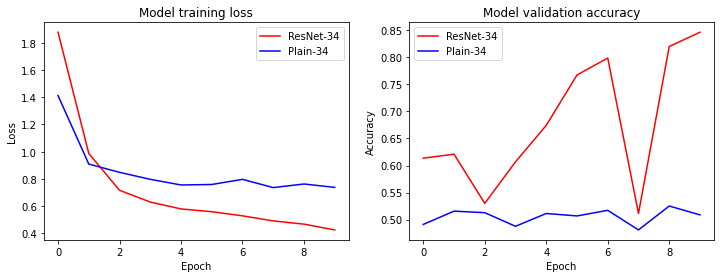

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

- ResNet-50 vs Plain-50 비교

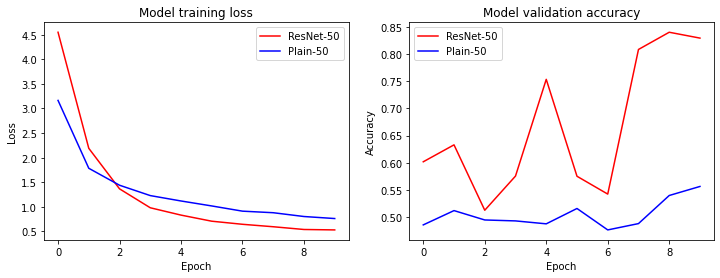

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

- 전체 비교

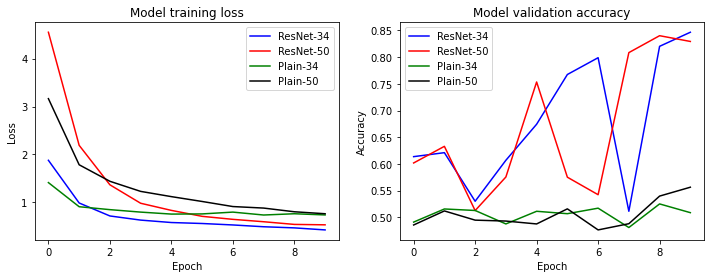

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

## 프로젝트 결과

+ Training Loss의 출발점은 Plain 모델이 ResNet보다 낮았는데 학습할수록 ResNet이 더 빠르게 낮아져서, 결국에는 ResNet이 더 낮은 0.5에 가깝게 수렴하였고, Plain 모델은 0.75에 가깝게 수렴한 것을 볼 수 있다.
+ Validation Accuracy는 처음부터 ResNet이 높게 시작하여 결국에는 0.8을 넘나드는 것을 볼 수 있는데 Plain 모델은 에폭이 진행되면서 거의 변화가 미미하고 10에폭 후에도 0.55에 조차 도달하지 못하는 그래프를 볼 수 있다.
+ Validation Accuracy 그래프에서 알 수 있는 것은 Plain 모델의 경우는 레이어가 깊어 진다고해서 학습이 잘 되는게 아니라는 것이고 ResNet처럼 skip connection이 존재해야만 레이어가 깊어질수록 학습이 잘된다는 점이다. 왜냐하면 ResNet-34와 ResNet-50 경우에도 에폭이 진행될수록 ResNet-50이 더 가파르게 Validation Accuracy가 증가하는게 보이기 때문이다. 만약 에폭을 더 늘렸다면 ResNet-34와 ResNet-50 사이에도 차이가 더 두드러질 것이라고 예상된다.